# L22_Neural_network

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import csv


In [44]:
data = np.genfromtxt('galaxyquasar.csv', delimiter=',', dtype = str)

In [45]:
u = data[1:,0].astype('float64')
g = data[1:,1].astype('float64')
r = data[1:,2].astype('float64')
i = data[1:,3].astype('float64')
z = data[1:,4].astype('float64')

r_i = r-i
i_z = i-z
u_g = u-g
g_r = g-r

#labels=0 if galaxy, labels=1 if quasar
labels = data[1:,5]
labels = np.where(labels=='GALAXY',0,1)

Let's rescale data such that their mean is going to be 0 and standard deviation 1, and let's split samples into train and test set.

In [46]:
#rescaling
r_i_norm = (r_i - np.mean(r_i))/np.std(r_i)
i_z_norm = (i_z - np.mean(i_z))/np.std(i_z)
u_g_norm = (u_g - np.mean(u_g))/np.std(u_g)
g_r_norm = (g_r - np.mean(g_r))/np.std(g_r)

normalized_colors = np.array([u_g_norm, g_r_norm, r_i_norm, i_z_norm]).T

#splitting (30% test)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_colors, labels, test_size=0.30)


I try to se MLPClassifier to implement a simple neural network. First, let's assign some values: one layer with 5 neurons, ReLU as activation function, let's keep the learning rate constant at 0.001 and let's take a solver 'adam'.

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from astroML.utils import completeness_contamination
from sklearn.metrics import accuracy_score

#implementing the neural network
mlpc = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', learning_rate='constant',
                                                    learning_rate_init=0.001, random_state=0, max_iter=500)
mlpc.fit(x_train, y_train)
y_pred = mlpc.predict(x_test)

y_prob = mlpc.predict_proba(x_test)[:,1] #predicted probability for each test sample to be a quasar
    
fpr_mlpc, tpr_mlpc, thresh_mlpc = roc_curve(y_test, y_prob) #roc curve

compl_mlpc, cont_mlpc = completeness_contamination(y_pred, y_test) #completeness contamination
acc_mlpc = accuracy_score(y_test, y_pred) #accuracy
    
fpr_mlpc = np.concatenate([[0], fpr_mlpc])
tpr_mlpc = np.concatenate([[0], tpr_mlpc])

Text(0.5, 1.0, 'completeness and efficiency')

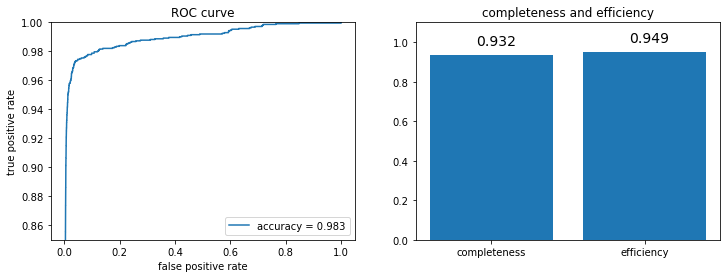

In [62]:
#plotting the results
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(fpr_mlpc, tpr_mlpc, label='accuracy = %.3f' %acc_mlpc)
ax[0].set_ylim(0.85, 1.)
ax[0].legend()
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].set_title('ROC curve')

feat = ('completeness', 'efficiency')
compl = [compl_mlpc, 1-cont_mlpc]

x_pos = np.arange(len(compl))
ax[1].bar(x_pos,compl)
ax[1].set_ylim(0,1.1)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(feat)
ax[1].text( -0.10, compl[0]+0.05, "%.3f" %compl[0], fontsize=14)
ax[1].text(1-0.10, compl[1]+0.05, "%.3f" %compl[1], fontsize=14)
ax[1].set_title('completeness and efficiency')


Wow! Results are already very good, but now let's try to optimize the parameters of the MLPC. For now let's stick to one layer, but now let GridSearchCV decide the optimal number of neurons as well as the activation function and the solver. This process takes a while!

In [65]:
#CV to obtain optimal parameters
from sklearn.model_selection import GridSearchCV

parameters = {'hidden_layer_sizes':np.arange(2,8), 'activation':['relu', 'tanh', 'logistic'], 'solver':['adam', 'sgd', 'lbfgs']}
grid = GridSearchCV(MLPClassifier(max_iter=500, random_state=0, learning_rate='adaptive',
                                 learning_rate_init=0.001), parameters, n_jobs=-1)

grid.fit(x_train, y_train)
opt_lay = grid.best_params_
print(opt_lay)

{'activation': 'tanh', 'hidden_layer_sizes': 6, 'solver': 'lbfgs'}


Let's try to put these parameters inside the MLPC to see if the results are different.

Text(0.5, 1.0, 'completeness and efficiency')

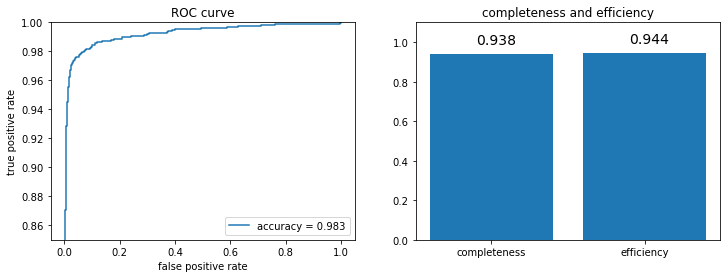

In [67]:
#Fit with the optimal parameters found above
mlpc1 = MLPClassifier(hidden_layer_sizes=(6), activation='tanh', solver='lbfgs', learning_rate='adaptive',
                                                    learning_rate_init=0.001, random_state=0)
mlpc1.fit(x_train, y_train)
y_pred = mlpc1.predict(x_test)

y_prob = mlpc1.predict_proba(x_test)[:,1] #predicted probability for each test sample to be a quasar
    
fpr_mlpc1, tpr_mlpc1, thresh_mlpc1 = roc_curve(y_test, y_prob) #roc curve

compl_mlpc1, cont_mlpc1 = completeness_contamination(y_pred, y_test) #completeness contamination
acc_mlpc1 = accuracy_score(y_test, y_pred) #accuracy
    
fpr_mlpc1 = np.concatenate([[0], fpr_mlpc1])
tpr_mlpc1 = np.concatenate([[0], tpr_mlpc1])

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(fpr_mlpc1, tpr_mlpc1, label='accuracy = %.3f' %acc_mlpc1)
ax[0].set_ylim(0.85, 1.)
ax[0].legend()
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].set_title('ROC curve')

feat = ('completeness', 'efficiency')
compl = [compl_mlpc1, 1-cont_mlpc1]

x_pos = np.arange(len(compl))
ax[1].bar(x_pos,compl)
ax[1].set_ylim(0,1.1)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(feat)
ax[1].text( -0.10, compl[0]+0.05, "%.3f" %compl[0], fontsize=14)
ax[1].text(1-0.10, compl[1]+0.05, "%.3f" %compl[1], fontsize=14)
ax[1].set_title('completeness and efficiency')


Accuracy is the same as before, but this time completeness has increased at the expenses of efficiency (contamination is higher too!). However the results are very close to what we had before, and a 98.3% of accuracy is a very good result in general!

What if we have 2 layers? Could it increase accuracy? Here I try to repeat the same process seen before but this time with two layers and some (not all because it would take too long) pairs of number of neurons among which the cross validation process could choose to get the optimal values. In particular I choose the couples such that the number of neurons in the second layer is less or equal to the number of neurons in the first one and the number of neurons in each layer is less than twice the number of dimensions we are using.

In [94]:
#creating couples
layers_range = []
n_range=np.arange(2,9)

for i in n_range:
    for j in n_range:
        if j <= i:
            layers_range.append([i,j])

print(layers_range)


[[2, 2], [3, 2], [3, 3], [4, 2], [4, 3], [4, 4], [5, 2], [5, 3], [5, 4], [5, 5], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8]]


In [95]:
#CV
parameters = {'hidden_layer_sizes':layers_range, 'activation':['relu', 'tanh', 'logistic'], 'solver':['adam', 'sgd', 'lbfgs']}

grid = GridSearchCV(MLPClassifier(max_iter=500, random_state=0, learning_rate='adaptive',
                                 learning_rate_init=0.001), parameters, n_jobs=-1)
grid.fit(x_train[:15000], y_train[:15000])
opt_2lay = grid.best_params_
print(opt_2lay)

{'activation': 'relu', 'hidden_layer_sizes': [8, 5], 'solver': 'adam'}


Text(0.5, 1.0, 'completeness and efficiency')

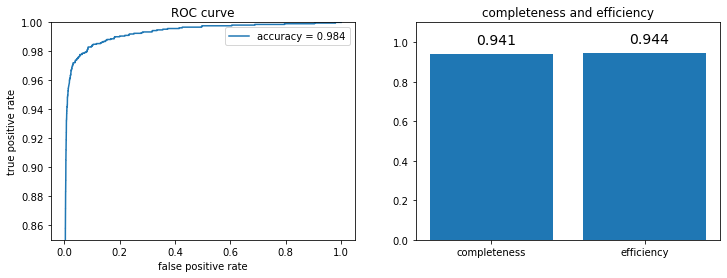

In [123]:
#fit with best parameters for 2 neurons

mlpc2 = MLPClassifier(hidden_layer_sizes=(8,5), activation='relu', solver='adam', learning_rate='adaptive',
                                                    learning_rate_init=0.001, random_state=0, max_iter=500)
mlpc2.fit(x_train, y_train)
y_pred = mlpc2.predict(x_test)

y_prob = mlpc2.predict_proba(x_test)[:,1] #predicted probability for each test sample to be a quasar
    
fpr_mlpc2, tpr_mlpc2, thresh_mlpc2 = roc_curve(y_test, y_prob) #roc curve

compl_mlpc2, cont_mlpc2 = completeness_contamination(y_pred, y_test) #completeness contamination
acc_mlpc2 = accuracy_score(y_test, y_pred) #accuracy
    
fpr_mlpc2 = np.concatenate([[0], fpr_mlpc2])
tpr_mlpc2 = np.concatenate([[0], tpr_mlpc2])

#plotting
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(fpr_mlpc2, tpr_mlpc2, label='accuracy = %.3f' %acc_mlpc2)
ax[0].set_ylim(0.85, 1.)
ax[0].legend()
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].set_title('ROC curve')

feat = ('completeness', 'efficiency')
compl = [compl_mlpc2, 1-cont_mlpc2]

x_pos = np.arange(len(compl))
ax[1].bar(x_pos,compl)
ax[1].set_ylim(0,1.1)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(feat)
ax[1].text( -0.10, compl[0]+0.05, "%.3f" %compl[0], fontsize=14)
ax[1].text(1-0.10, compl[1]+0.05, "%.3f" %compl[1], fontsize=14)
ax[1].set_title('completeness and efficiency')


Well, the difference is not that much from before, therefore we can consider also our first try to have good hyperparameters!

If compared to the generative classification methods used in the exercise L19 the resulting completeness and efficiency are comparable to the ones found with KNN or GMMBayes, however, in this case, the process is way more time consuming.

Let's see the difference between the initial distribution and the after-classification one.

Text(0.5, 0, 'i-z')

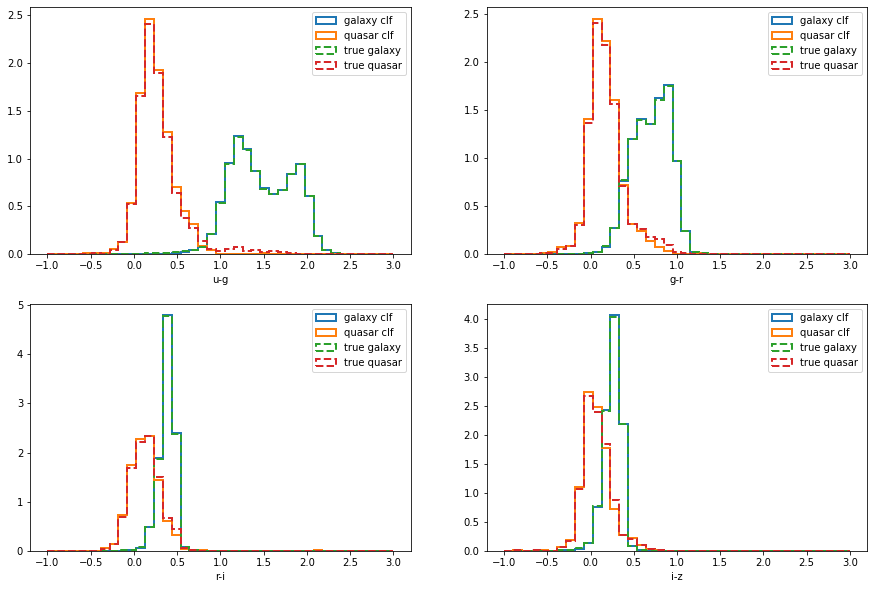

In [130]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax=ax.reshape(4)

#plotting rescaled data
#u-g
ax[0].hist(x_test[:,0][y_pred==0]*np.std(u_g)+np.mean(u_g), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='galaxy clf', lw=2)
ax[0].hist(x_test[:,0][y_pred==1]*np.std(u_g)+np.mean(u_g), bins=np.linspace(-1,3,40), density=True, histtype='step', label='quasar clf', lw=2)
ax[0].hist(x_test[:,0][y_test==0]*np.std(u_g)+np.mean(u_g), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='true galaxy', ls='--', lw=2)
ax[0].hist(x_test[:,0][y_test==1]*np.std(u_g)+np.mean(u_g), bins=np.linspace(-1,3,40), density=True, histtype='step', label='true quasar', ls='--', lw=2)
ax[0].legend()
ax[0].set_xlabel('u-g')
#g-r
ax[1].hist(x_test[:,1][y_pred==0]*np.std(g_r)+np.mean(g_r), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='galaxy clf', lw=2)
ax[1].hist(x_test[:,1][y_pred==1]*np.std(g_r)+np.mean(g_r), bins=np.linspace(-1,3,40), density=True, histtype='step', label='quasar clf', lw=2)
ax[1].hist(x_test[:,1][y_test==0]*np.std(g_r)+np.mean(g_r), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='true galaxy', ls='--', lw=2)
ax[1].hist(x_test[:,1][y_test==1]*np.std(g_r)+np.mean(g_r), bins=np.linspace(-1,3,40), density=True, histtype='step', label='true quasar', ls='--', lw=2)
ax[1].legend()
ax[1].set_xlabel('g-r')
#r-i
ax[2].hist(x_test[:,2][y_pred==0]*np.std(r_i)+np.mean(r_i), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='galaxy clf', lw=2)
ax[2].hist(x_test[:,2][y_pred==1]*np.std(r_i)+np.mean(r_i), bins=np.linspace(-1,3,40), density=True, histtype='step', label='quasar clf', lw=2)
ax[2].hist(x_test[:,2][y_test==0]*np.std(r_i)+np.mean(r_i), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='true galaxy', ls='--', lw=2)
ax[2].hist(x_test[:,2][y_test==1]*np.std(r_i)+np.mean(r_i), bins=np.linspace(-1,3,40), density=True, histtype='step', label='true quasar', ls='--', lw=2)
ax[2].legend()
ax[2].set_xlabel('r-i')
#i-z
ax[3].hist(x_test[:,3][y_pred==0]*np.std(i_z)+np.mean(i_z), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='galaxy clf', lw=2)
ax[3].hist(x_test[:,3][y_pred==1]*np.std(i_z)+np.mean(i_z), bins=np.linspace(-1,3,40), density=True, histtype='step', label='quasar clf', lw=2)
ax[3].hist(x_test[:,3][y_test==0]*np.std(i_z)+np.mean(i_z), bins=np.linspace(-1,3, 40), density=True, histtype='step', label='true galaxy', ls='--', lw=2)
ax[3].hist(x_test[:,3][y_test==1]*np.std(i_z)+np.mean(i_z), bins=np.linspace(-1,3,40), density=True, histtype='step', label='true quasar', ls='--', lw=2)
ax[3].legend()
ax[3].set_xlabel('i-z')


The discrepancy between the true and the classified distributions is more evident in the quasar histogram, since they are normalised histograms, but quasars are way less than galaxies, therefore a small change can result in higher discrepancy of counts per bin. The results obtained are definitely comparable with the ones found in L19!